### 2d Experiment using RCPS \& Proto-RCPS
- Create multivariate gaussian mixture:

$$
\mathcal{D} = 

\frac{1}{3}
\mathcal{N}([0,0]^T, \begin{bmatrix}
1 & 0 \\
0 & 1 
\end{bmatrix}) 
+

\frac{1}{3}
\mathcal{N}([3,3]^T, \begin{bmatrix}
0.5 & 0.2 \\
0.2 & 0.5 
\end{bmatrix}) 
+

\frac{1}{3}
\mathcal{N}([-3,-4]^T, \begin{bmatrix}
0.7 & -0.2 \\
-0.2 & 0.7 
\end{bmatrix}) 
$$

- $30.000$ Samples
- **RCPS**: $50 \times 50 = 2500$ bin centers. $X \in \{-7,7\}$ , $Y \in \{-7, 7\}$
- **RCPS-Proto**: $50 \times 50 = 2500$ prototypes initialized at $X \in \{-7,7\}$ , $Y \in \{-7, 7\}$


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection

from scipy.stats import multivariate_normal
from scipy.spatial import Voronoi, voronoi_plot_2d

import torch
import torch.nn as nn


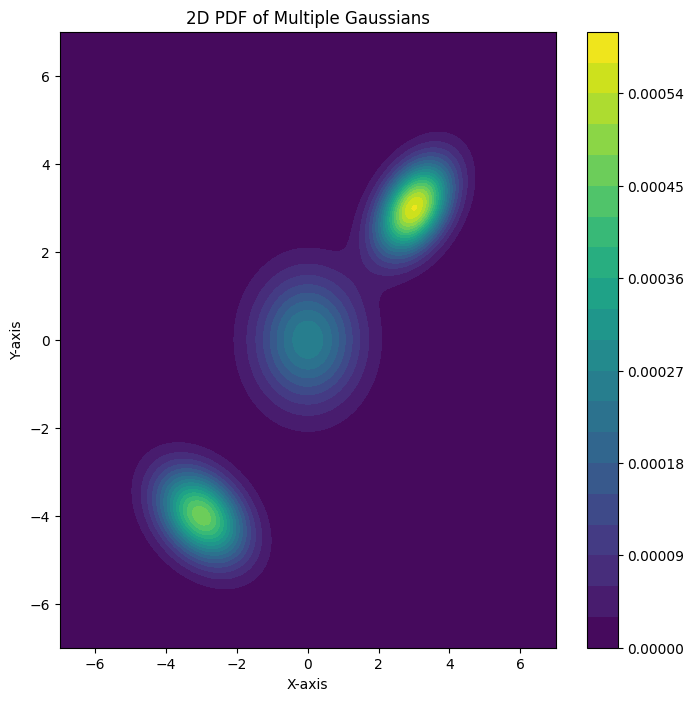

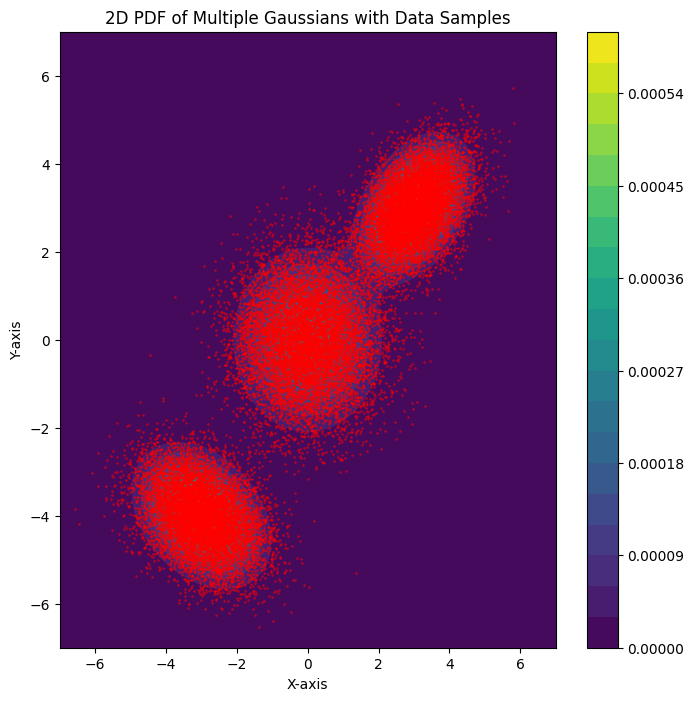

In [21]:
np.random.seed(0)

# Centers of the Gaussians
means = [(0, 0), 
         (3, 3), 
         (-3, -4)]  
# Covariance matrices
covariances = [ [[1, 0], 
                 [0, 1]], 
               [[0.5, 0.2], 
                [0.2, 0.5]], 
               [[0.7, -0.2], 
                [-0.2, 0.5]] ] 
# Number of data samples
sizes = [10000,
         10000,
         10000]

# Grid space (-7,7)x(-7,7)
x = np.linspace(-7, 7, 200)
y = np.linspace(-7, 7, 200)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

# Create the combined Gaussian distribution
Z = np.zeros(X.shape)
data_samples = []
for mean, cov, size in zip(means, covariances, sizes):
    # Generate data samples from the Gaussian
    rv = np.random.multivariate_normal(mean, cov, size=size)
    data_samples.append(rv)
    
    # Add the Gaussian PDF contribution to the grid
    rv_pdf = multivariate_normal(mean, cov).pdf(pos)
    # Z += np.exp(-0.5 * (np.sum(np.dot(pos - mean, np.linalg.inv(cov)) * (pos - mean), axis=2))) * np.linalg.det(cov)**(-1/2) * size
    Z += rv_pdf * size  # Weight by the number of samples for each distribution

data_samples = np.vstack(data_samples)

# Normalize the combined distribution
Z /= np.sum(Z)

# Plot the 2D PDF
plt.figure(figsize=(8, 8))
plt.contourf(X, Y, Z, levels=20, cmap='viridis')
plt.colorbar()
plt.title('2D PDF of Multiple Gaussians')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

# Plot the 2D PDF with data samples
plt.figure(figsize=(8, 8))
plt.contourf(X, Y, Z, levels=20, cmap='viridis')
plt.colorbar()
plt.scatter(data_samples[:,0], data_samples[:,1], c='r', s=1, marker='x', alpha=0.5)
plt.title('2D PDF of Multiple Gaussians with Data Samples')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()


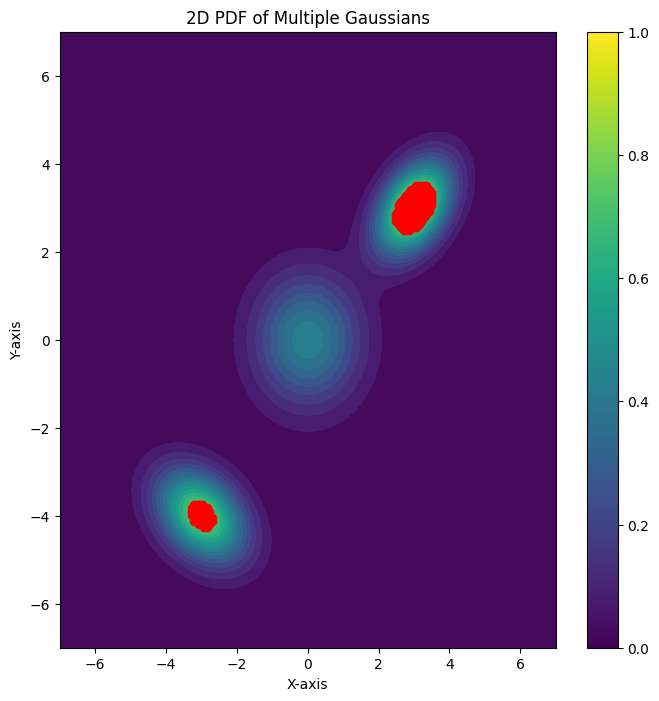

In [22]:
# Flatten the Z array and sort it in descending order
Z_flat = Z.flatten()
sorted_indices = np.argsort(Z_flat)[::-1]
sorted_Z = Z_flat[sorted_indices]

# Calculate the cumulative sum and find the threshold index
cumulative_sum = np.cumsum(sorted_Z)
threshold_index = np.where(cumulative_sum >= 0.1)[0][0]

# Get the x, y coordinates for the corresponding indices
top_indices = sorted_indices[:threshold_index+1]
top_x = X.flatten()[top_indices]
top_y = Y.flatten()[top_indices]

plt.figure(figsize=(8, 8))
# Plot the 2D PDF
plt.contourf(X, Y, Z, levels=20, cmap='viridis')
plt.scatter(top_x, top_y, c='red')
plt.colorbar()
plt.title('2D PDF of Multiple Gaussians')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()


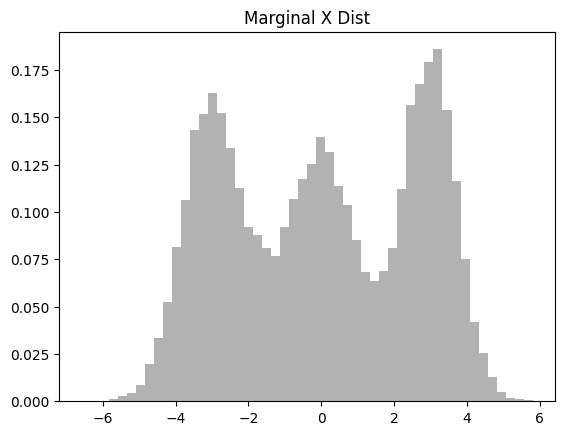

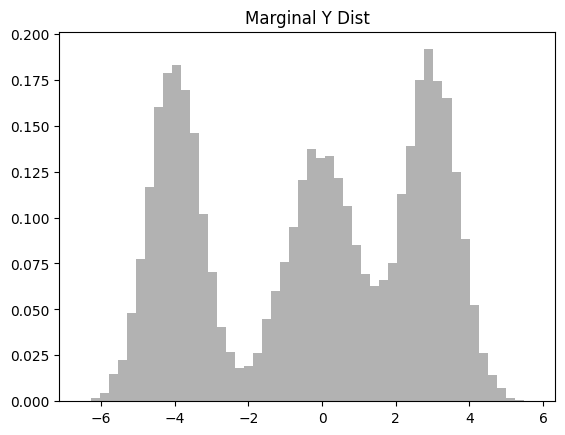

In [23]:
# Get X Centers
plt.figure()
plt.title("Marginal X Dist")
X_bin_count = 50
X_hist = plt.hist(data_samples[:,0], bins=X_bin_count, density=True, alpha=0.6, color='gray', label='Data')
X_digital_labels = np.fmin(np.digitize(data_samples[:,0], X_hist[1]), X_bin_count)

# Get Y Centers
plt.figure()
plt.title("Marginal Y Dist")
Y_bin_count = 50
Y_hist = plt.hist(data_samples[:,1], bins=Y_bin_count, density=True, alpha=0.6, color='gray', label='Data')
Y_digital_labels = np.fmin(np.digitize(data_samples[:,1], Y_hist[1]), Y_bin_count)

digital_labels = ((X_digital_labels-1) + (Y_digital_labels-1) * Y_bin_count)

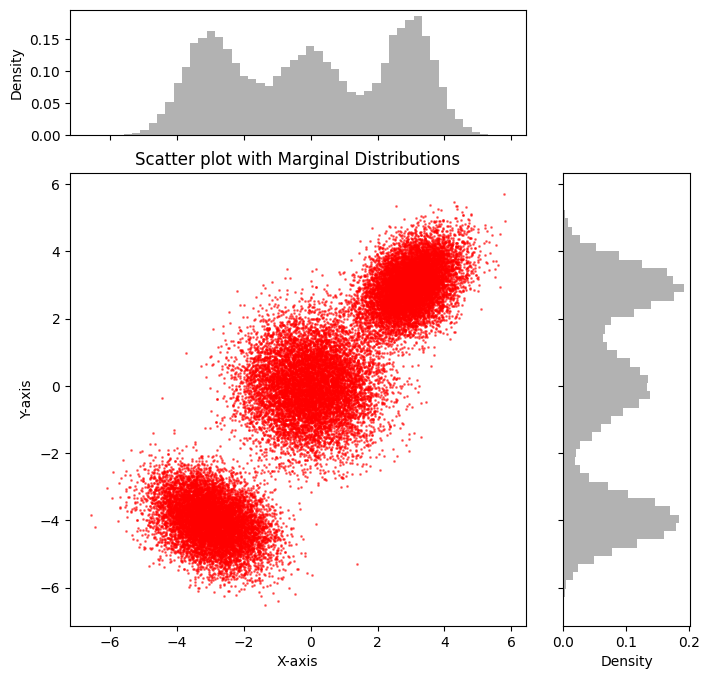

In [24]:
# Create a figure with a main plot area and two marginal histograms
from matplotlib import gridspec

# Set up the figure with specified size and gridspec
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(4, 4, hspace=0.3, wspace=0.3)

# Main scatter plot
ax_main = fig.add_subplot(gs[1:4, 0:3])
ax_main.scatter(data_samples[:, 0], data_samples[:, 1], c='r', s=1, alpha=0.5)
ax_main.set_xlabel('X-axis')
ax_main.set_ylabel('Y-axis')
ax_main.set_title('Scatter plot with Marginal Distributions')

# Marginal histogram for X
ax_histx = fig.add_subplot(gs[0, 0:3], sharex=ax_main)
ax_histx.hist(data_samples[:, 0], bins=X_bin_count, density=True, alpha=0.6, color='gray')
ax_histx.set_ylabel('Density')
ax_histx.tick_params(axis='x', labelbottom=False)  # Hide x labels for top histogram

# Marginal histogram for Y
ax_histy = fig.add_subplot(gs[1:4, 3], sharey=ax_main)
ax_histy.hist(data_samples[:, 1], bins=Y_bin_count, density=True, alpha=0.6, color='gray', orientation='horizontal')
ax_histy.set_xlabel('Density')
ax_histy.tick_params(axis='y', labelleft=False)  # Hide y labels for right histogram

plt.show()


In [25]:
def get_cuda_summary(memory=False):
    import torch

    if torch.cuda.is_available():
        print('CUDA device = ', torch.cuda.get_device_name())
        print('Available number of devices = ', torch.cuda.device_count())
        print('Device numbers              = ', list(range(torch.cuda.device_count())))
        print('Current device              = ', torch.cuda.current_device())
        if memory:
            print(torch.cuda.memory_summary())
    else:
        print('cuda is not available')

import torch
get_cuda_summary()
device = torch.device(0) if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.set_device(0) if torch.cuda.is_available() else None

CUDA device =  NVIDIA TITAN RTX
Available number of devices =  1
Device numbers              =  [0]
Current device              =  0


In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UnconditionalClassifier(nn.Module):
    def __init__(self, in_size = 1, no_of_classes=50*50):
        super(UnconditionalClassifier, self).__init__()
        self.in_size = in_size
        self.no_of_classes = no_of_classes
        self.hidden_size = 256
        self.net = nn.Sequential(
            nn.Linear(self.in_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.no_of_classes),
        )
        
    def forward(self, x):
        x = self.net(x)
        return x

In [27]:
# CROSS ENTROPY LOSS
train_y = torch.from_numpy((digital_labels).reshape(-1)).to(device)
train_x = torch.zeros_like(train_y).reshape(-1,1).float().to(device)

model = UnconditionalClassifier().to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model.parameters(), lr=3e-4)

In [28]:
losses = []
for step in range(2000):
    model.train()
    #yq1, yq2, yq3 = model(x)
    #loss = criterion(input=(yq1, yq2, yq3), target=y)
    logits = model(train_x)
    loss = criterion(logits, train_y)
    losses.append(loss.data.item())
    #print(yqs.shape, train_y_tr.shape)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (step==0) or ((step+1) % 100 == 0):
        """
        Show your intermediate results
        """
        print('epoch {} loss={:.4}'.format(step+1, loss.data.item()))
        pass

epoch 1 loss=7.834
epoch 100 loss=6.256
epoch 200 loss=6.246
epoch 300 loss=6.244
epoch 400 loss=6.244
epoch 500 loss=6.243
epoch 600 loss=6.243
epoch 700 loss=6.243
epoch 800 loss=6.243
epoch 900 loss=6.243
epoch 1000 loss=6.243
epoch 1100 loss=6.243
epoch 1200 loss=6.243
epoch 1300 loss=6.243
epoch 1400 loss=6.243
epoch 1500 loss=6.243
epoch 1600 loss=6.243
epoch 1700 loss=6.243
epoch 1800 loss=6.243
epoch 1900 loss=6.243
epoch 2000 loss=6.243


In [29]:
def moving_average(a, n=2):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
X_bin_centers = moving_average(X_hist[1])
Y_bin_centers = moving_average(Y_hist[1])

xx, yy = np.meshgrid(X_bin_centers, Y_bin_centers)
cluster_coordinates = np.array(list(zip(xx.flatten(), yy.flatten()))).shape

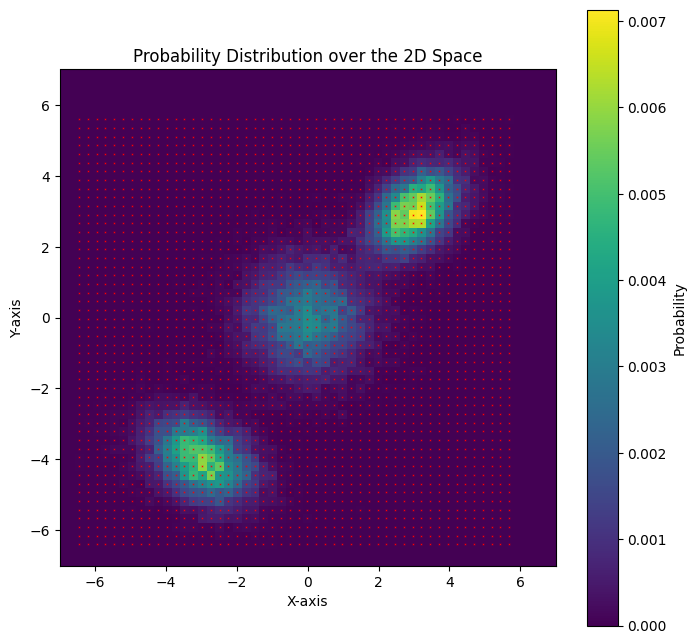

In [30]:
# Ensure the model is in evaluation mode
model.eval()

# Feed the input tensor with value 0
input_tensor = torch.zeros(1, 1).to(device)  # Batch size of 1, input size of 1

# Generate model predictions
with torch.no_grad():  # Disable gradient calculation for inference
    output_logits = model(input_tensor)

# Apply softmax to get the probability distribution over the output classes
output_probs = torch.softmax(output_logits, dim=1).cpu().numpy().reshape(50, 50)

# Use the pre-computed bin edges for X and Y (X_hist[1] and Y_hist[1])
x_edges = X_hist[1]  # Assuming X_hist[1] contains the bin edges for X
y_edges = Y_hist[1]  # Assuming Y_hist[1] contains the bin edges for Y

# Plot the probability distribution over the 2D grid using the bin edges
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)  # nrows, ncols, index

# Get the colormap and set the color for under 0 values
cmap = plt.get_cmap('viridis')

# Set vmin to 0 to make sure the zero probability regions are colored
im = ax.imshow(output_probs, extent=(x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]), 
               origin='lower', cmap=cmap, vmin=0, vmax=output_probs.max())

# Set the facecolor of the axes to the color corresponding to the lowest value in the colormap
ax.set_facecolor(cmap(0))  # This sets the background to the same color as the lowest probability

# Set the xlim and ylim with no extra background
plt.xlim(-7, 7)
plt.ylim(-7, 7)

# Add the colorbar and labels
plt.colorbar(im, ax=ax, label='Probability')
plt.title('Probability Distribution over the 2D Space')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Display proto centers
xx, yy = np.meshgrid(X_bin_centers, Y_bin_centers)
plt.scatter(xx.flatten(), yy.flatten(), marker='x', c='red', s=0.1)
plt.show()


In [31]:
######### PROTOTYPE 1 ####################33

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UnconditionalProtoClassifier(nn.Module):
    def __init__(self, in_size = 1, no_of_classes=50*50):
        super(UnconditionalProtoClassifier, self).__init__()
        self.in_size = in_size
        self.no_of_classes = no_of_classes
        self.hidden_size = 256
        self.net = nn.Sequential(
            nn.Linear(self.in_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.no_of_classes),
        )
        
    def forward(self, x):
        x = self.net(x)
        return x

In [37]:
def moving_average(a, n=2):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
X_bin_centers = moving_average(X_hist[1])
Y_bin_centers = moving_average(Y_hist[1])

xx, yy = np.meshgrid(X_bin_centers, Y_bin_centers)
cluster_coordinates = np.array(list(zip(xx.flatten(), yy.flatten()))).shape

initial_prototypes = np.stack([xx.flatten(), yy.flatten()], axis=1)

In [38]:
# CROSS ENTROPY LOSS
protos = nn.Parameter(torch.Tensor(initial_prototypes).to(device) ,requires_grad=True)

# CROSS ENTROPY LOSS
train_y = torch.from_numpy(data_samples).to(torch.float32).to(device)
train_x = torch.zeros(train_y.size(0)).reshape(-1,1).float().to(device)


model = UnconditionalProtoClassifier().to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=list(model.parameters())+ [protos], lr=0.05)


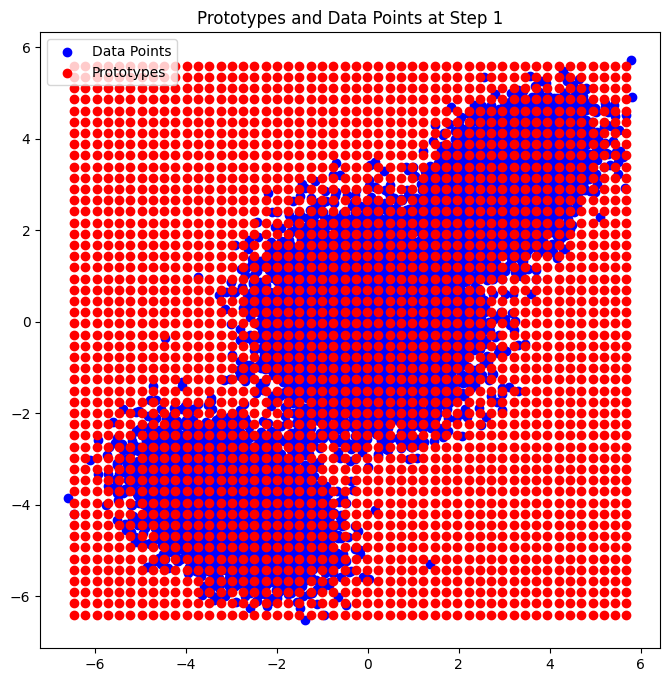

epoch 1, loss=0.8676, CE_Loss: 0.7829388976097107, MinDist_Loss: 0.08468875288963318


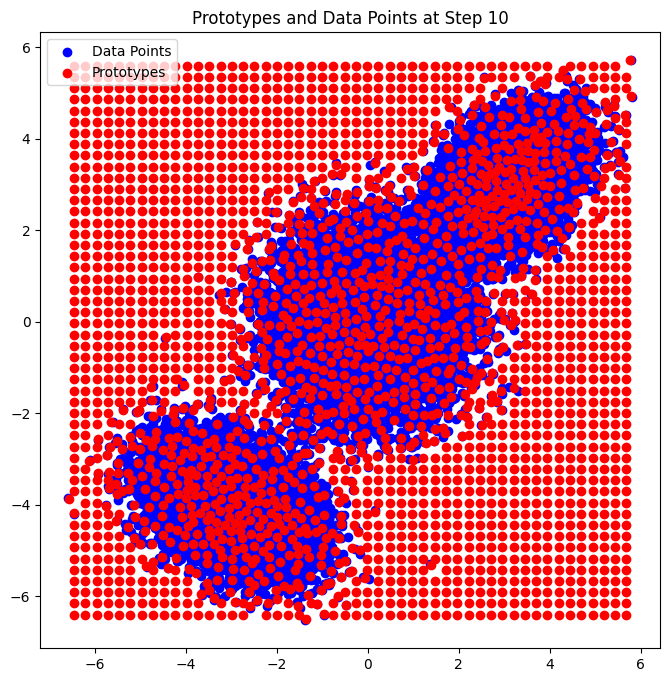

epoch 10, loss=0.7341, CE_Loss: 0.6603058576583862, MinDist_Loss: 0.07384006679058075


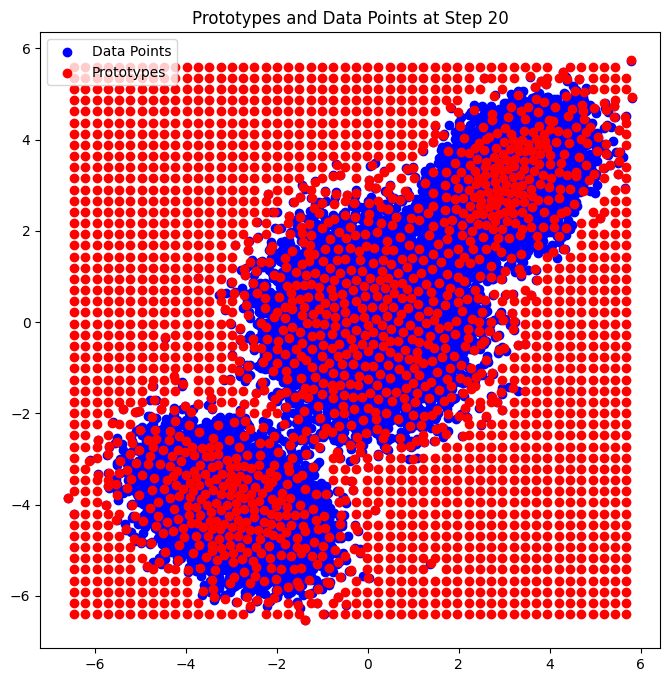

epoch 20, loss=0.7205, CE_Loss: 0.650318443775177, MinDist_Loss: 0.07020291686058044


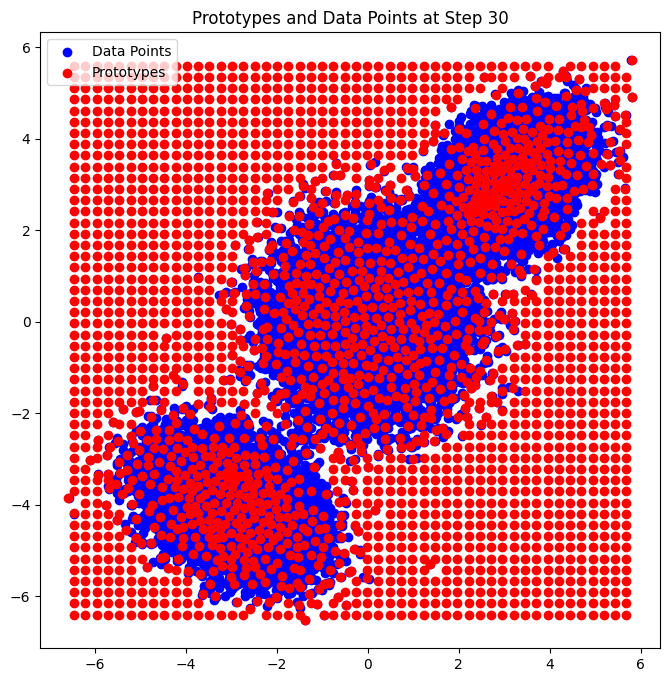

epoch 30, loss=0.7213, CE_Loss: 0.6531215906143188, MinDist_Loss: 0.06819935888051987


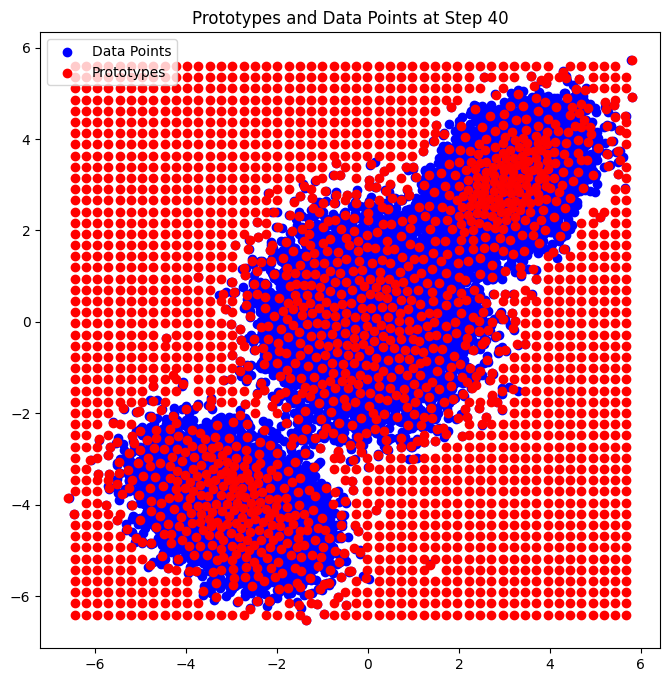

epoch 40, loss=0.7214, CE_Loss: 0.6542200446128845, MinDist_Loss: 0.06721241772174835


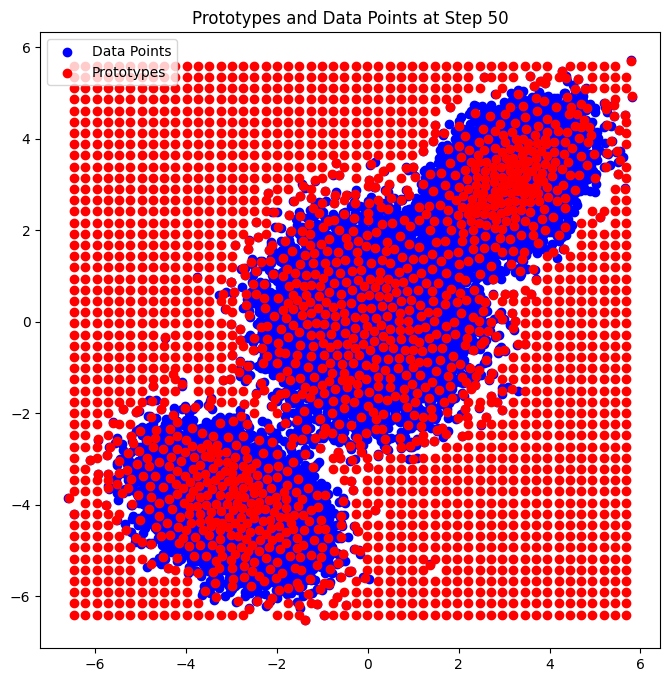

epoch 50, loss=0.7213, CE_Loss: 0.6546052098274231, MinDist_Loss: 0.06666599959135056


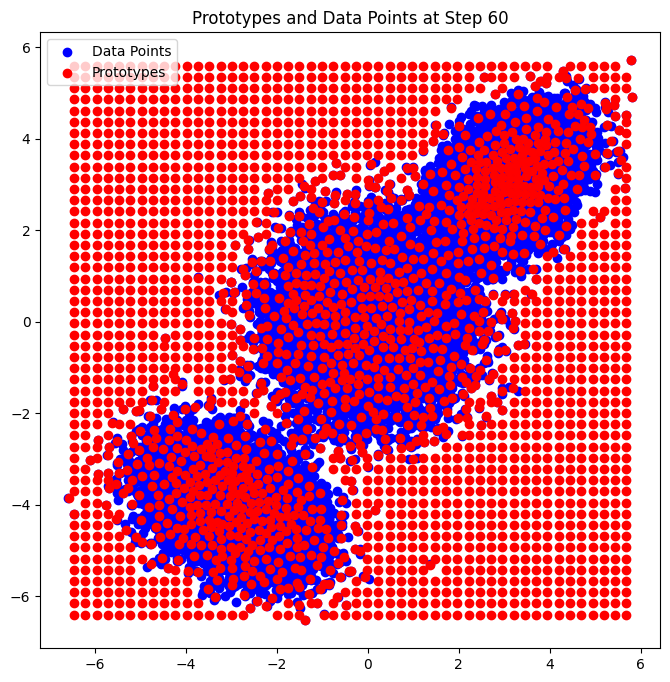

epoch 60, loss=0.7212, CE_Loss: 0.6547801494598389, MinDist_Loss: 0.06638077646493912


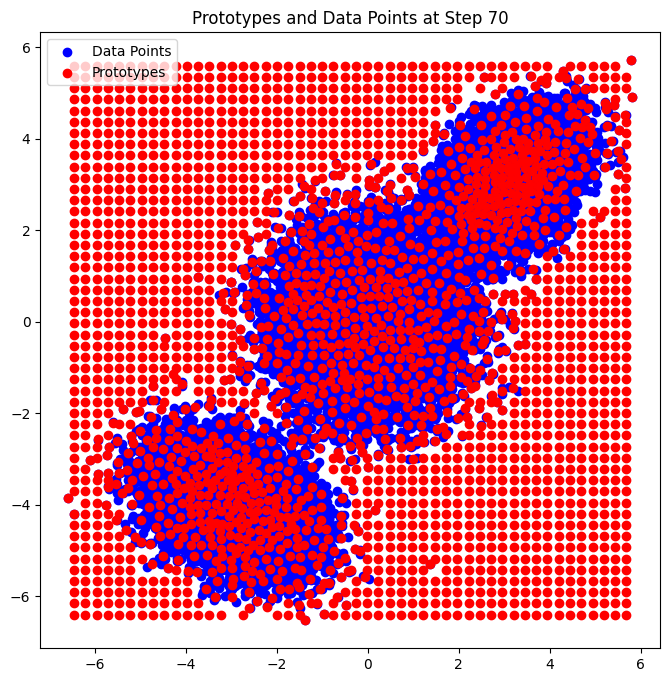

epoch 70, loss=0.7212, CE_Loss: 0.6549230813980103, MinDist_Loss: 0.06624288111925125


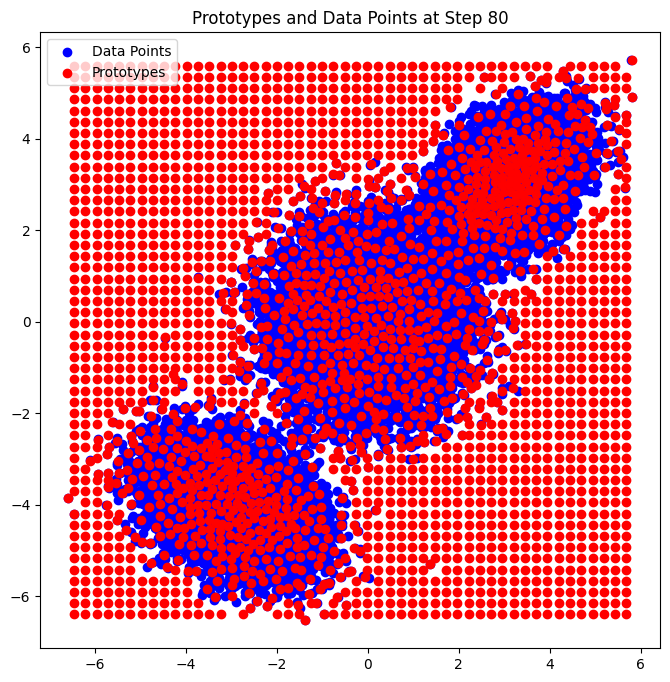

epoch 80, loss=0.7211, CE_Loss: 0.6548859477043152, MinDist_Loss: 0.06617800891399384


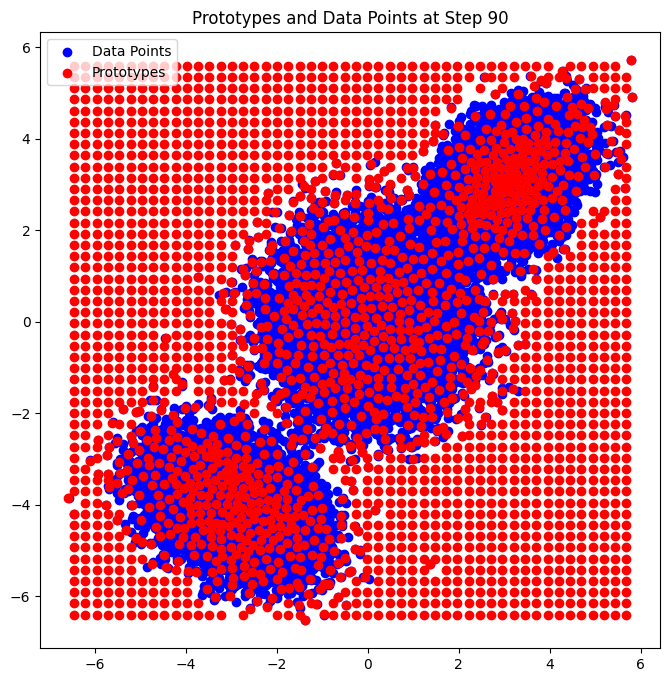

epoch 90, loss=0.721, CE_Loss: 0.6548423171043396, MinDist_Loss: 0.0661417543888092


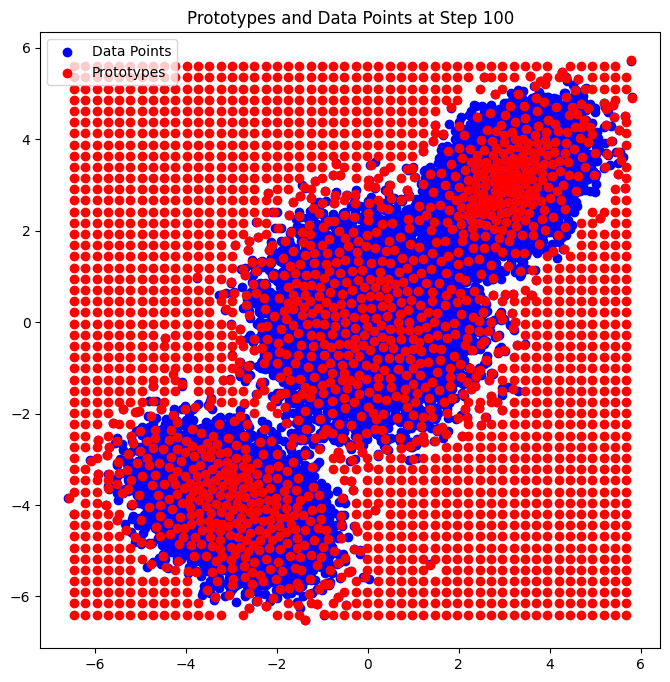

epoch 100, loss=0.721, CE_Loss: 0.6548550724983215, MinDist_Loss: 0.06611029803752899


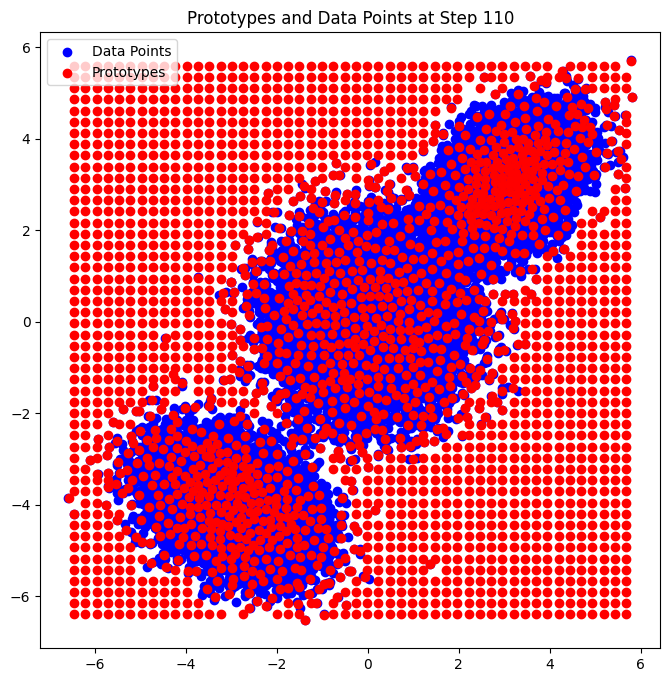

epoch 110, loss=0.7209, CE_Loss: 0.6548389792442322, MinDist_Loss: 0.06608366221189499


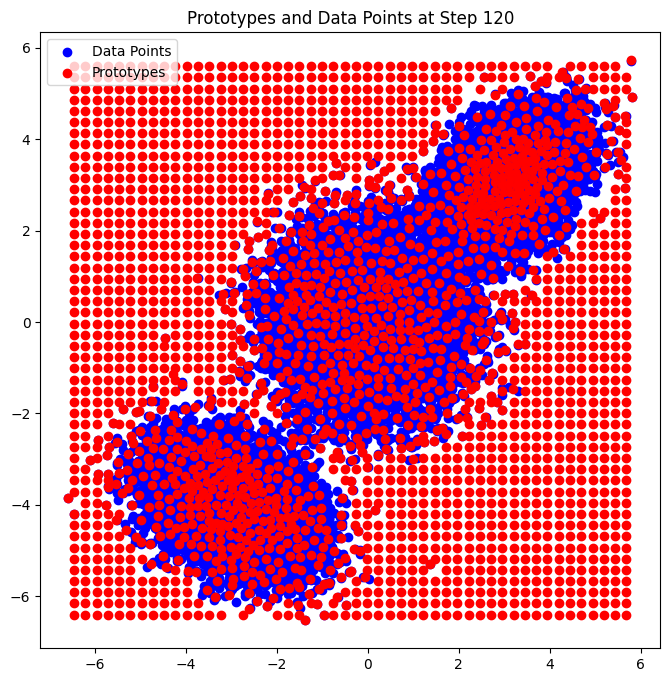

epoch 120, loss=0.7209, CE_Loss: 0.6547902226448059, MinDist_Loss: 0.06606695801019669


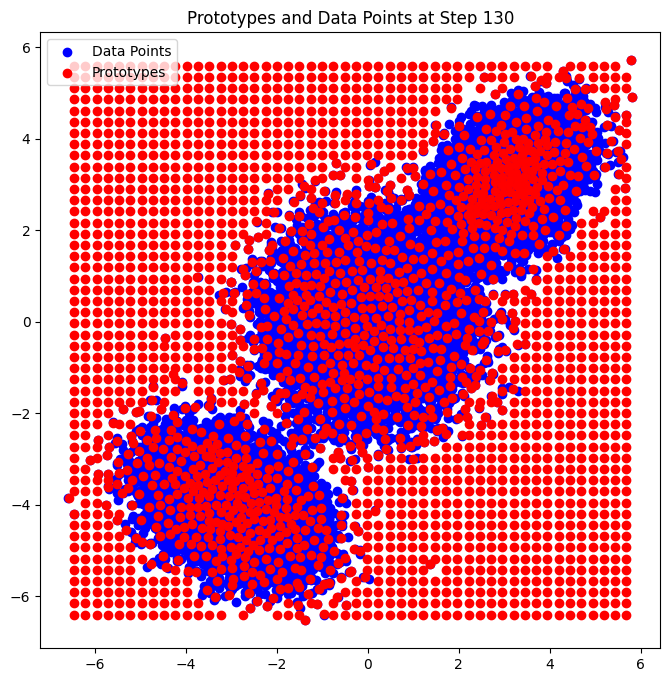

epoch 130, loss=0.7208, CE_Loss: 0.6547593474388123, MinDist_Loss: 0.06606186181306839


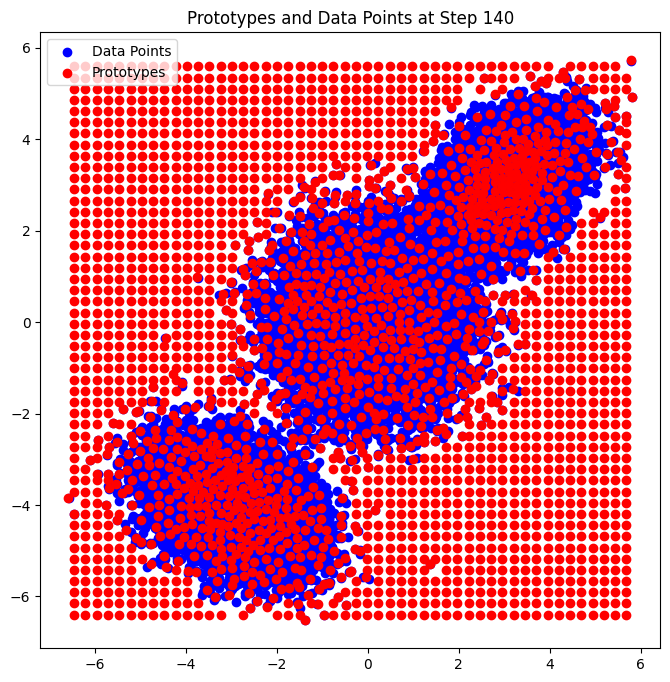

epoch 140, loss=0.7208, CE_Loss: 0.6547395586967468, MinDist_Loss: 0.06606102734804153


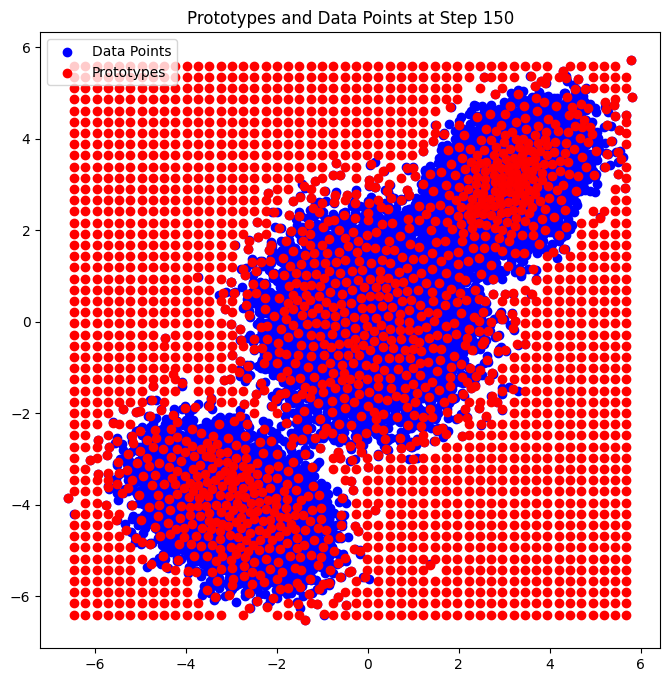

epoch 150, loss=0.7208, CE_Loss: 0.6547426581382751, MinDist_Loss: 0.06606071442365646


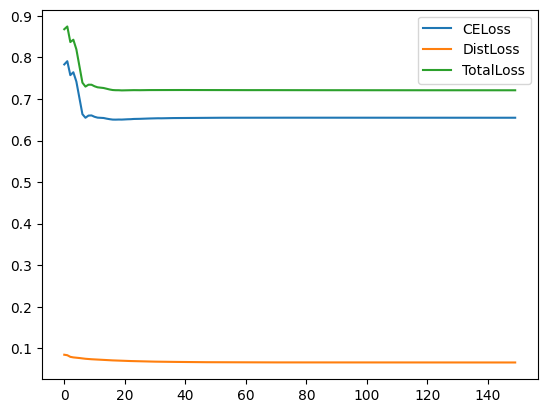

In [39]:
ce_losses = []
mindist_losses = []

losses = []
for step in range(150):

    if (step==0) or ((step+1) % 10 == 0):
        # Visualize protos
        plt.figure(figsize=(8, 8))
        plt.scatter(train_y.cpu().numpy()[:, 0], train_y.cpu().numpy()[:, 1], c='blue', label='Data Points')
        plt.scatter(protos.detach().cpu().numpy()[:, 0], protos.detach().cpu().numpy()[:, 1], c='red', label='Prototypes')
        plt.title(f'Prototypes and Data Points at Step {step+1}')
        plt.legend()
        plt.show()
        
    model.train()
    optimizer.zero_grad()
    #yq1, yq2, yq3 = model(x)
    #loss = criterion(input=(yq1, yq2, yq3), target=y)
    logits = model(train_x)
    
    cdist_list = torch.cdist(train_y, protos, p=2)
    mindist, pos = torch.min(cdist_list, dim=1)
    
    lambda_fact = 0.9
    ce_loss = (1-lambda_fact) * criterion(logits, pos)
    mindist_loss = lambda_fact * torch.mean(mindist)
    loss = ce_loss + mindist_loss
    
    ce_losses.append(ce_loss.data.item())
    mindist_losses.append(mindist_loss.data.item())
    losses.append(loss.data.item())
    #print(yqs.shape, train_y_tr.shape)
    loss.backward()
    optimizer.step()

    if (step==0) or ((step+1) % 10 == 0):
        print(f'epoch {step+1}, loss={loss.data.item():.4}, CE_Loss: {ce_loss.data.item()}, MinDist_Loss: {mindist_loss.data.item()}')

plt.plot(ce_losses, label='CELoss')
plt.plot(mindist_losses, label='DistLoss')
plt.plot(losses, label='TotalLoss')
plt.legend()

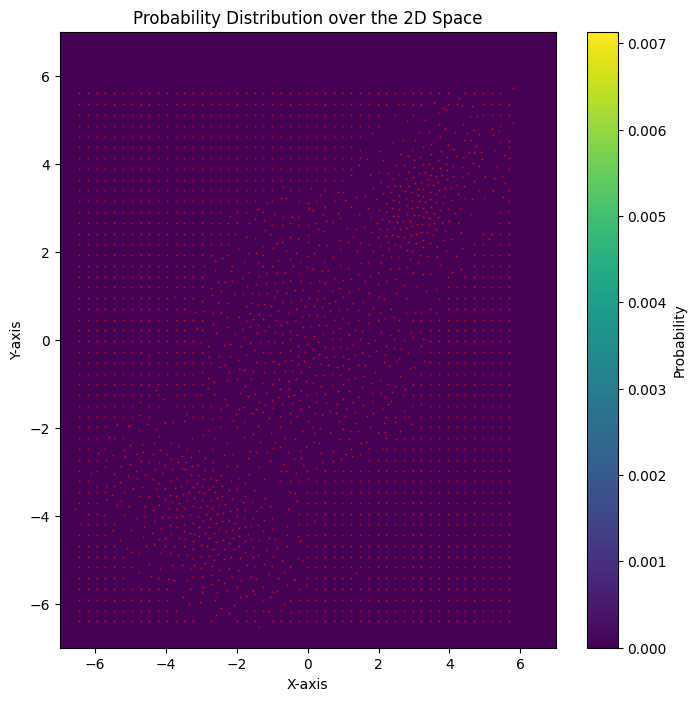

In [40]:
# Ensure the model is in evaluation mode
model.eval()

# Feed the input tensor with value 0
input_tensor = torch.zeros(1, 1).to(device)  # Batch size of 1, input size of 1

# Generate model predictions
with torch.no_grad():  # Disable gradient calculation for inference
    output_logits = model(input_tensor)

# Apply softmax to get the probability distribution over the output classes
output_probs = torch.softmax(output_logits, dim=1).cpu().numpy().reshape(50, 50)

# Use the pre-computed bin edges for X and Y (X_hist[1] and Y_hist[1])
x_edges = X_hist[1]  # Assuming X_hist[1] contains the bin edges for X
y_edges = Y_hist[1]  # Assuming Y_hist[1] contains the bin edges for Y

# Plot the probability distribution over the 2D grid using the bin edges
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)  # nrows, ncols, index

# Get the colormap and set the color for under 0 values
cmap = plt.get_cmap('viridis')

# Set vmin to 0 to make sure the zero probability regions are colored
# im = ax.imshow(output_probs, extent=(x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]), 
#                origin='lower', cmap=cmap, vmin=0, vmax=output_probs.max())

# Set the facecolor of the axes to the color corresponding to the lowest value in the colormap
ax.set_facecolor(cmap(0))  # This sets the background to the same color as the lowest probability

# Set the xlim and ylim with no extra background
plt.xlim(-7, 7)
plt.ylim(-7, 7)

# Add the colorbar and labels
plt.colorbar(im, ax=ax, label='Probability')
plt.title('Probability Distribution over the 2D Space')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Display proto centers
xx, yy = np.meshgrid(protos[:,0].detach().cpu().numpy(), protos[:,0].detach().cpu().numpy())
plt.scatter(protos[:,0].detach().cpu().numpy(), protos[:,1].detach().cpu().numpy(), marker='x', c='red', s=0.1)
plt.show()


In [18]:
output_probs

array([[3.6152954e-08, 3.6297223e-08, 4.2498613e-08, ..., 4.7778915e-08,
        4.4365791e-08, 4.0107999e-08],
       [4.6520146e-08, 3.7992901e-08, 4.6961887e-08, ..., 4.2585352e-08,
        4.3589161e-08, 5.5772556e-08],
       [4.2075492e-08, 3.9008292e-08, 3.8538754e-08, ..., 4.2256286e-08,
        4.0192617e-08, 3.8693653e-08],
       ...,
       [3.8373283e-08, 4.1837975e-08, 4.7423196e-08, ..., 4.7949360e-08,
        4.5707022e-08, 4.4372225e-08],
       [4.4593325e-08, 4.6160057e-08, 3.7664392e-08, ..., 4.5902901e-08,
        4.5762331e-08, 3.5927691e-08],
       [3.9751495e-08, 4.1007006e-08, 4.4056655e-08, ..., 4.4954394e-08,
        4.3277346e-08, 3.3788609e-05]], dtype=float32)

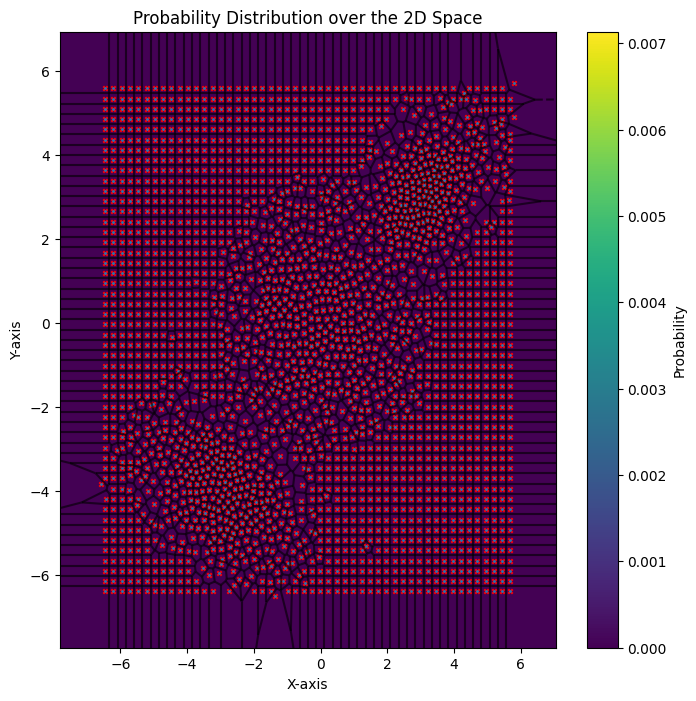

In [42]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

# Ensure the model is in evaluation mode
model.eval()

# Feed the input tensor with value 0
input_tensor = torch.zeros(1, 1).to(device)  # Batch size of 1, input size of 1

# Generate model predictions
with torch.no_grad():  # Disable gradient calculation for inference
    output_logits = model(input_tensor)

# Apply softmax to get the probability distribution over the output classes
output_probs = torch.softmax(output_logits, dim=1).cpu().numpy().reshape(50, 50)

# Use the pre-computed bin edges for X and Y (X_hist[1] and Y_hist[1])
x_edges = X_hist[1]  # Assuming X_hist[1] contains the bin edges for X
y_edges = Y_hist[1]  # Assuming Y_hist[1] contains the bin edges for Y

# Plot the probability distribution over the 2D grid using the bin edges
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)  # nrows, ncols, index

cmap = plt.get_cmap('viridis')
ax.set_facecolor(cmap(0))  

# Set the xlim and ylim with no extra background
plt.xlim(-7, 7)
plt.ylim(-7, 7)

# Add the colorbar and labels
plt.colorbar(im, ax=ax, label='Probability')
plt.title('Probability Distribution over the 2D Space')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Display proto centers
proto_centers = protos.detach().cpu().numpy()
plt.scatter(proto_centers[:, 0], proto_centers[:, 1], marker='x', c='red', s=10)

# Perform Voronoi tessellation
vor = Voronoi(proto_centers)

# Plot the Voronoi diagram (without points)
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='k', line_width=1.5, line_alpha=0.6, point_size=2)

plt.show()


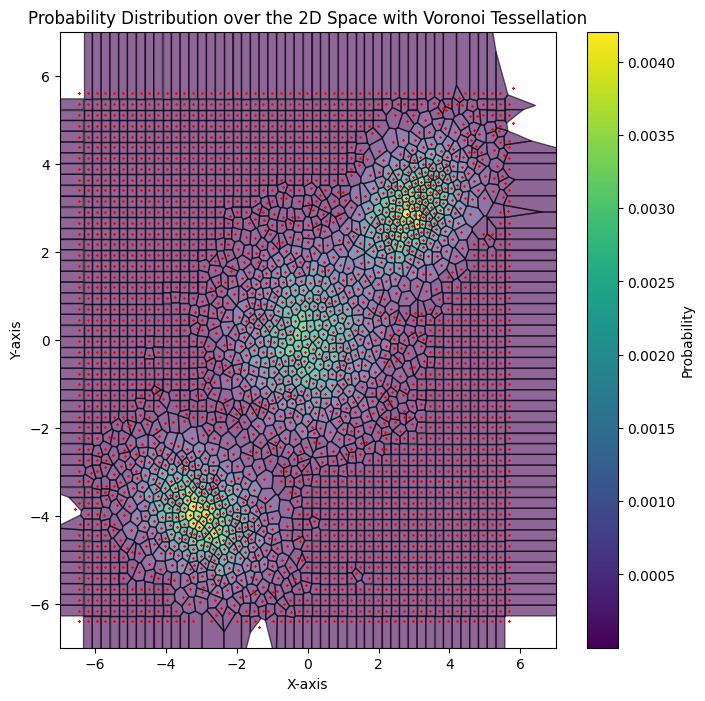

In [61]:


# Ensure the model is in evaluation mode
model.eval()

# Feed the input tensor with value 0
input_tensor = torch.zeros(1, 1).to(device)  # Batch size of 1, input size of 1

# Generate model predictions
with torch.no_grad():  # Disable gradient calculation for inference
    output_logits = model(input_tensor)

# Apply softmax to get the probability distribution over the output classes
output_probs = torch.softmax(output_logits, dim=1).cpu().numpy()

# Use the pre-computed bin edges for X and Y (X_hist[1] and Y_hist[1])
x_edges = X_hist[1]  # Assuming X_hist[1] contains the bin edges for X
y_edges = Y_hist[1]  # Assuming Y_hist[1] contains the bin edges for Y

# Flatten the output probabilities to match with the prototypes
flat_probs = output_probs.flatten()

# Display prototype centers
proto_centers = protos.detach().cpu().numpy()

# Perform Voronoi tessellation
vor = Voronoi(proto_centers)

# Generate colormap
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(vmin=flat_probs.min(), vmax=flat_probs.max())

# Plot the probability distribution over the 2D grid using the bin edges
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)  # nrows, ncols, index

# Plot each Voronoi region with color corresponding to the prototype's probability
regions = []
colors = []

# Loop through each prototype and its corresponding Voronoi region
for i, region_index in enumerate(vor.point_region):
    region = vor.regions[region_index]
    
    # Only include finite Voronoi regions (no infinite vertices, i.e., no '-1' in region)
    if not -1 in region and len(region) > 0:
        polygon = [vor.vertices[j] for j in region]
        regions.append(polygon)
        # Map the prototype's probability to the region color
        colors.append(cmap(norm(flat_probs[i])))

# Create a PolyCollection for Voronoi regions
voronoi_region_collection = PolyCollection(regions, facecolors=colors, edgecolors='k', alpha=0.6)
ax.add_collection(voronoi_region_collection)

# Plot prototype centers
ax.scatter(proto_centers[:, 0], proto_centers[:, 1], marker='x', c='red', s=1)

# Set the axis limits and labels
plt.xlim(-7, 7)
plt.ylim(-7, 7)
plt.title('Probability Distribution over the 2D Space with Voronoi Tessellation')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label='Probability')

plt.show()


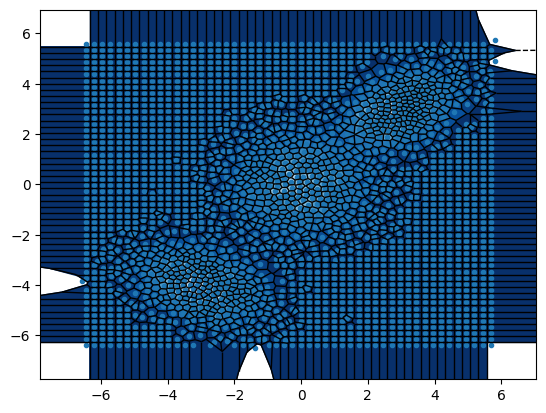

In [55]:
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

# generate data/speed values
points = proto_centers
speed = flat_probs

# generate Voronoi tessellation
vor = Voronoi(points)

# find min/max values for normalization
minima = min(speed)
maxima = max(speed)

# normalize chosen colormap
norm = mpl.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.Blues_r)

# plot Voronoi diagram, and fill finite regions with color mapped from speed value
voronoi_plot_2d(vor, show_points=True, show_vertices=False, s=1)
for r in range(len(vor.point_region)):
    region = vor.regions[vor.point_region[r]]
    if not -1 in region:
        polygon = [vor.vertices[i] for i in region]
        plt.fill(*zip(*polygon), color=mapper.to_rgba(speed[r]))

(array([1840.,  206.,  111.,  124.,   80.,   77.,   41.,   12.,    7.,
           2.]),
 array([2.8447182e-08, 4.2050972e-04, 8.4099104e-04, 1.2614724e-03,
        1.6819536e-03, 2.1024349e-03, 2.5229161e-03, 2.9433975e-03,
        3.3638787e-03, 3.7843601e-03, 4.2048413e-03], dtype=float32),
 <BarContainer object of 10 artists>)

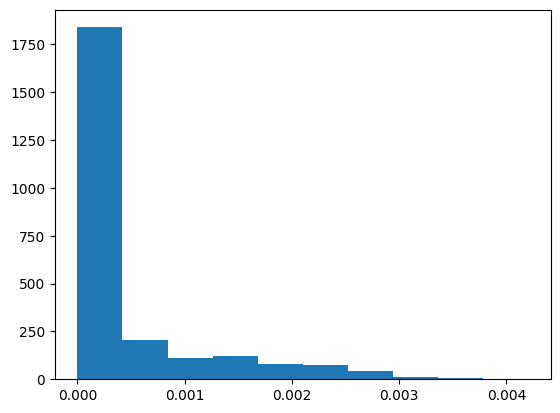

In [60]:
plt.hist(flat_probs)

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

# generate data/speed values
points = proto_centers
speed = output_probs.flatten()

# generate Voronoi tessellation
vor = Voronoi(points)

# find min/max values for normalization
minima = min(speed)
maxima = max(speed)

# normalize chosen colormap
norm = mpl.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.Blues_r)

# plot Voronoi diagram, and fill finite regions with color mapped from speed value
voronoi_plot_2d(vor, show_points=True, show_vertices=False, s=1)
for r in range(len(vor.point_region)):
    region = vor.regions[vor.point_region[r]]
    if not -1 in region:
        polygon = [vor.vertices[i] for i in region]
        plt.fill(*zip(*polygon), color=mapper.to_rgba(speed[r]))